In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf

2023-12-31 10:33:01.095853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 10:33:01.921295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1 Model loading
I use model trained in the prior notebook on the MNIST dataset. I freeze all the layers and change the last Dense class adding one extra class that represents the unreadable digits/wrongly segmented digits.

In [2]:
base_model = tf.keras.models.load_model('models/mnist-cnn.keras')

In [3]:
def get_base_model(print=False):
    model = tf.keras.Sequential()
    for layer in base_model.layers[:-1]:
        model.add(layer)
        model.layers[-1].trainable = False
    
    model.add(tf.keras.layers.Dense(11, activation='softmax', name='new_dense'))
    model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy())
    if print:
        model.summary()
    return model

get_base_model(print=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 28, 28, 1)         │          3 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 27, 27, 64)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 27, 27, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)        │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 64)          │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 5, 5, 64)          │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    204,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ new_dense (Dense)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 238,915 (933.27 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 238,915 (933.27 KB)

<Sequential name=sequential, built=False>

# 2 Labeling
Manually label hand-written digits that were obtained, segmented and preprocessed in the first three notebooks. There are no labels at all. I gradually annotated aproximately 2300 digits. On the remaining 1000 I wanted to try semi-supervised self learning. Cell below is commented out since the sufficient number of digits were anotated.

Also during this annotation I was testing the prediction given by the MNIST model. That yielded accuracy around 0.29 which is very poor. The second inference is done by the model that was currently trained on the newly annotated data to see the performance.

In [4]:
# base_model = tf.keras.models.load_model('models/mnist-cnn.keras')
# df = pd.read_csv('digits.csv')
# stats = pd.read_csv('stats.csv')

# true_cnt = stats.loc[0, 'true']
# total_cnt = stats.loc[0, 'all']

# for idx, row in df.loc[df['label'].isna(), :].iterrows():
#     img = row.drop('label').to_numpy()
#     img = img.astype(np.float32)
#     img_show = img.reshape(28, 28)
#     plt.figure(figsize=(1,1))
#     plt.imshow(img_show)
#     plt.show()    
    
#     img = img.reshape(-1, 28, 28, 1)
#     res = model(img)
#     print(((np.argmax(res), np.max(res))))
#     res2 = base_model(img)
#     print(((np.argmax(res2), np.max(res2))))

#     label = input()
#     df.loc[idx, 'label'] = label
#     total_cnt += 1
#     true_cnt += 1 if label == str(np.argmax(res)) else 0

In [5]:
# df.to_csv('digits.csv', index=False)

# stats = pd.DataFrame([{'true': true_cnt, 'all': total_cnt, 'ratio': true_cnt/total_cnt}])
# stats.to_csv('stats.csv', index=False)

In [6]:
pd.read_csv('stats.csv')

true   all     ratio
0   667  2260  0.295133

# 3 Model training
Training the model on the annotated dataset. Training is done with transfer learning using the MNIST model from the previous notebook. It performed slightly better than just a plain new model with the random weights.

After the base training I unfreeze the frozen layers from the base model and fine-tune the model with the very little learning rate and low number of iterations as was recommended in the [Tensorflow documentation](https://www.tensorflow.org/guide/keras/transfer_learning#transfer_learning_fine-tuning_with_a_custom_training_loop).

In [7]:
def get_data(source_file):
    df = pd.read_csv(source_file, low_memory=False)
    df = df.loc[~df['label'].isna(), :]
    df['label'] = df['label'].apply(lambda x: 10 if x == 'x' else x)
    
    return train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=11)

In [8]:
def train_model(model, model_name, source_file, verbose=0):
    X_train, X_valid, y_train, y_valid = get_data(source_file)
    X_train = X_train.astype(np.float32)
    X_valid = X_valid.astype(np.float32)
    
    X_train = X_train.values.reshape(-1, 28, 28, 1)
    X_valid = X_valid.values.reshape(-1, 28, 28, 1)
    y_train = y_train.to_numpy().astype(np.float32).astype('int')
    y_valid = y_valid.to_numpy().astype(np.float32).astype('int')
    
    image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=False,
        zoom_range=0.1,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    image_data_generator.fit(X_train)
    augmented_iterator = image_data_generator.flow(X_train, y_train, batch_size=128)
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=0)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'models/{model_name}.keras')
    model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer=tf.keras.optimizers.Adam())
    history = model.fit(augmented_iterator, batch_size=128, epochs=500, validation_data=(X_valid, y_valid), verbose=verbose, callbacks=[early_stop, model_checkpoint_callback])
    
    model.load_weights(f'models/{model_name}.keras')

    # Fine-tuning
    base_model.trainable = True
    model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer=tf.keras.optimizers.Adam(1e-5))
    model.fit(augmented_iterator, epochs=10, validation_data=(X_valid, y_valid), verbose=verbose)
    
    eval = model.evaluate(X_valid, y_valid)
    return model, history, eval

model, history, eval = train_model(get_base_model(), 'base-custom-cnn', 'digits-train.csv', 1)

Epoch 1/500


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 909.7487 - sparse_categorical_accuracy: 0.0940 - val_loss: 635.7927 - val_sparse_categorical_accuracy: 0.2123
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 562.8790 - sparse_categorical_accuracy: 0.2086 - val_loss: 347.4543 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 454.6388 - sparse_categorical_accuracy: 0.2409 - val_loss: 242.3429 - val_sparse_categorical_accuracy: 0.4765
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 375.9485 - sparse_categorical_accuracy: 0.3296 - val_loss: 181.3954 - val_sparse_categorical_accuracy: 0.5457
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 326.5906 - sparse_categorical_accuracy: 0.3827 - val_loss: 155.4648 - val_sparse_categorical_accuracy: 0.6123
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 298.3566 - sparse_categorical_accuracy: 0.4070 - val_loss: 141.3528 - val_sparse_categorical_accuracy:

In [9]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

# 4 Test Data
75% sparse categorical accuracy is very solid for the input data of such kind. And confusion matrix looks also good.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1460 - sparse_categorical_accuracy: 0.7219 
[4.825280666351318, 0.7191489338874817]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


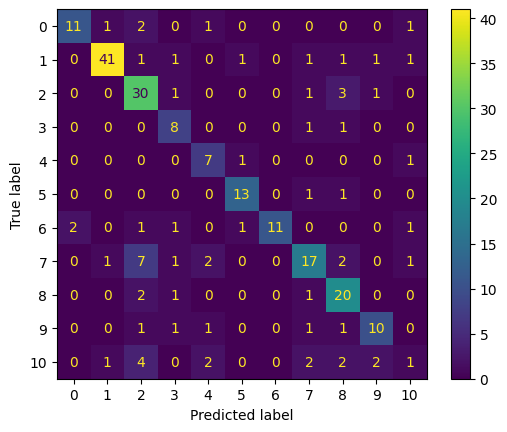

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

df = pd.read_csv('digits-test.csv')
X_test = df.drop('label', axis=1)
y_test = df['label'].to_numpy().astype(np.float32).astype('int')
X_test = X_test.astype(np.float32)
X_test = X_test.values.reshape(-1, 28, 28, 1)

print(model.evaluate(X_test, y_test))

class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, [i for i in range(0,11)])
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)
model.save('models/custom-data-cnn.keras')

# 5 Semi-supervised self learning
I tried this approach to get labels for the rest of the data. My approach was following:
1. For the 260 unlabeled images, predict them with the current model and put the to the training dataset.
2. Repeat until there are no unlabeled images

Unfortunately this did not work well, categorical accuracy went gradually down. So at the end I did not use this approach.

In [10]:
iteration = 1
source_file = 'digits-train.csv'
eval_models = []
df = pd.read_csv('digits-train.csv')

while len(df[df['label'].isna()]) != 0:
    labeled = 0

    # Model part
    print(f'Training, iteration: {iteration}')
    model = get_base_model()
    model, history, eval = train_model(model, f'{iteration}-semi-supervised', source_file, verbose=0)
    eval_models.append({'val_loss': eval[0], 'metrics': eval[1]})
    pd.DataFrame(eval_models).to_csv('eval_models.csv', index=False)
    print('Augmenting')
    
    for idx, row in df.loc[df['label'].isna(), :].iterrows():
    
        if labeled >= 260:
            break

        img = row.drop('label').to_numpy()
        img = img.astype(np.float32)
        img = img.reshape(-1, 28, 28, 1)
        res = model(img)
        df.loc[idx, 'label'] = np.argmax(res)
        labeled += 1
    
    df.to_csv(f'digits-augmented-{iteration}.csv', index=False)
    source_file = f'digits-augmented-{iteration}.csv'
    iteration += 1

Training, iteration: 1


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6654 - sparse_categorical_accuracy: 0.7397
Augmenting
Training, iteration: 2


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0752 - sparse_categorical_accuracy: 0.7206
Augmenting
Training, iteration: 3


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0165 - sparse_categorical_accuracy: 0.7337
Augmenting
Training, iteration: 4


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2773 - sparse_categorical_accuracy: 0.7374
Augmenting
Training, iteration: 5


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8524 - sparse_categorical_accuracy: 0.7361
Augmenting
Training, iteration: 6


/home/vojta/.conda/envs/kapri/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0377 - sparse_categorical_accuracy: 0.7322
Augmenting


In [58]:
df = pd.read_csv('eval_models.csv')
sns.lineplot(df, x=df.index, y='metrics', marker='o')
plt.title('Categorical accuracy for each iteration')
plt.xlabel('Itearation of self learning')
plt.ylabel('Categorical accuracy')
plt.show()